<a href="https://colab.research.google.com/github/kLahari28/project/blob/main/azure_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shaunthesheep_microsoft_catsvsdogs_dataset_path = kagglehub.dataset_download('shaunthesheep/microsoft-catsvsdogs-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'))
n_cats = len(os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

In [ ]:
#Define data path
CAT_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

0
0
0
0
0
0


In [ ]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

In [ ]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)


Split sucessful!
Split sucessful!


In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

11250
11250
625
625
625
625


In [ ]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [ ]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


In [ ]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

In [ ]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    # Changed generator.next() to next(generator)
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

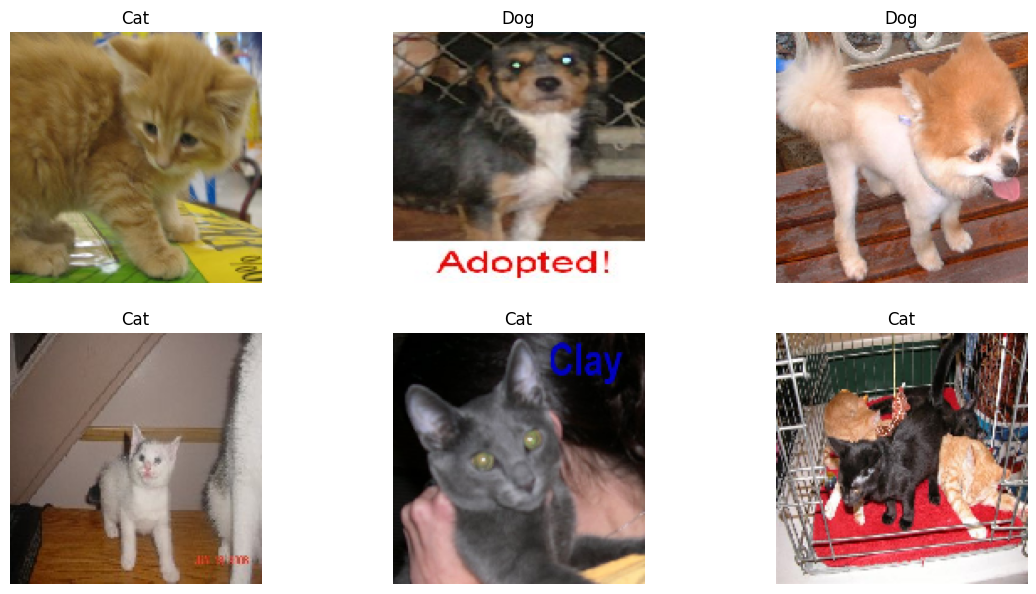

In [ ]:
plot_data(train_generator,7)

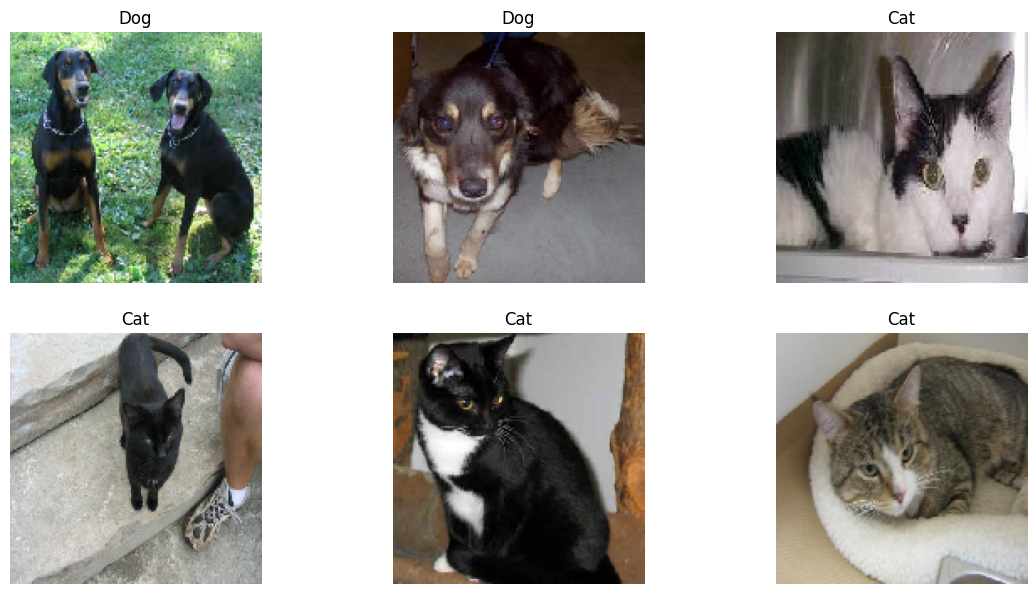

In [ ]:
plot_data(validation_generator,7)

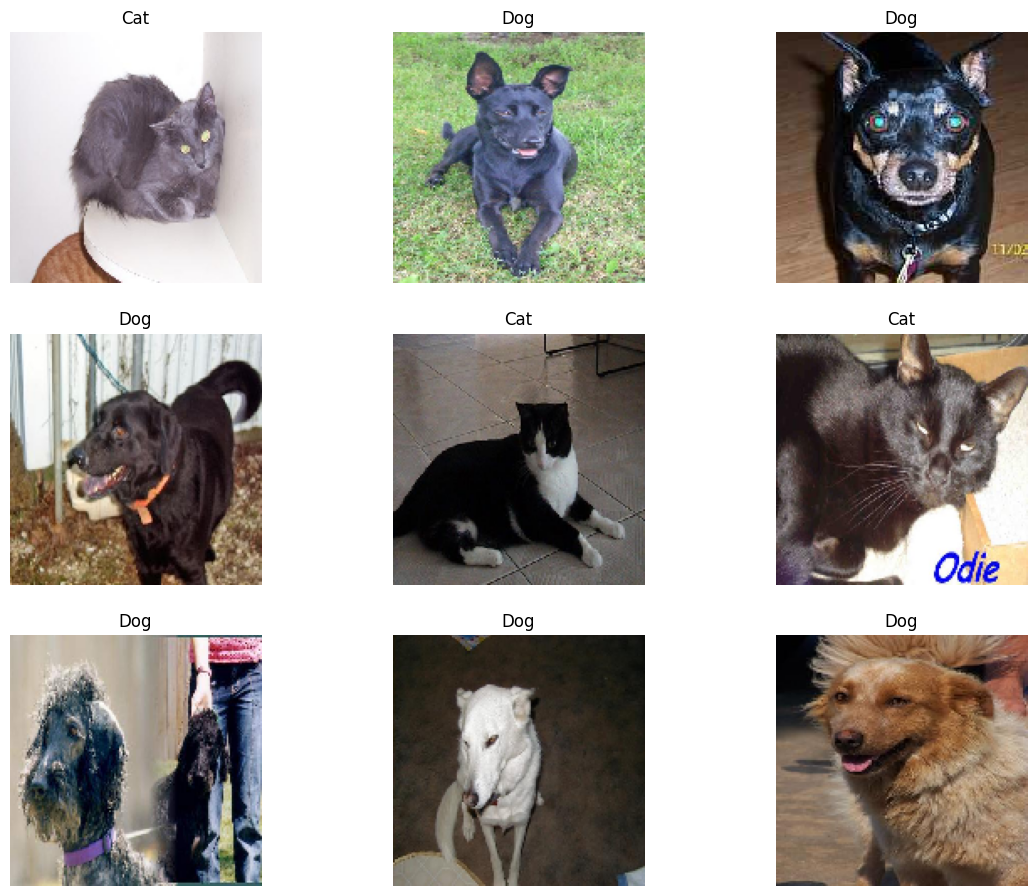

In [ ]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

In [ ]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
323/352 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5122 - loss: 0.6927

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning:

Truncated File Read



352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 191ms/step - accuracy: 0.5146 - loss: 0.6923 - val_accuracy: 0.6080 - val_loss: 0.6547
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.6027 - loss: 0.6615 - val_accuracy: 0.6816 - val_loss: 0.6165
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.6564 - loss: 0.6156 - val_accuracy: 0.6888 - val_loss: 0.5916
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.6823 - loss: 0.5955 - val_accuracy: 0.7032 - val_loss: 0.5742
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.7056 - loss: 0.5741 - val_accuracy: 0.7328 - val_loss: 0.5415
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.7146 - loss: 0.5593 - val_accuracy: 0.6864 - val_loss: 0.6038
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.7265 - loss: 0.5462 - val_accuracy: 0.7392 - val_loss: 0.5369
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.7445 - loss: 0.5240 - val

In [ ]:
results = pd.DataFrame(r.history)
results.tail()

,accuracy,loss,val_accuracy,val_loss
5,0.718953,0.553877,0.6864,0.603767
6,0.730420,0.540764,0.7392,0.536941
7,0.745933,0.522443,0.7800,0.493351
8,0.757623,0.503864,0.6584,0.648076
9,0.772158,0.483117,0.8096,0.438172


In [ ]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()